In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import centroid
import os
import shutil
from shapely import MultiPolygon, Polygon, wkt, intersection
import matplotlib.pyplot as plt
from geopy import distance
import pandas_geojson as pdg
import shapely
import reading_data


# Plotting precinct boundaries and polling locations

In [4]:
cen = gpd.read_file('../project_data/processed_data/Chicago_geocensus_data.geojson')

In [5]:
precs = gpd.read_file('../project_data/final_dataset/final_dataset_Chicago.geojson')


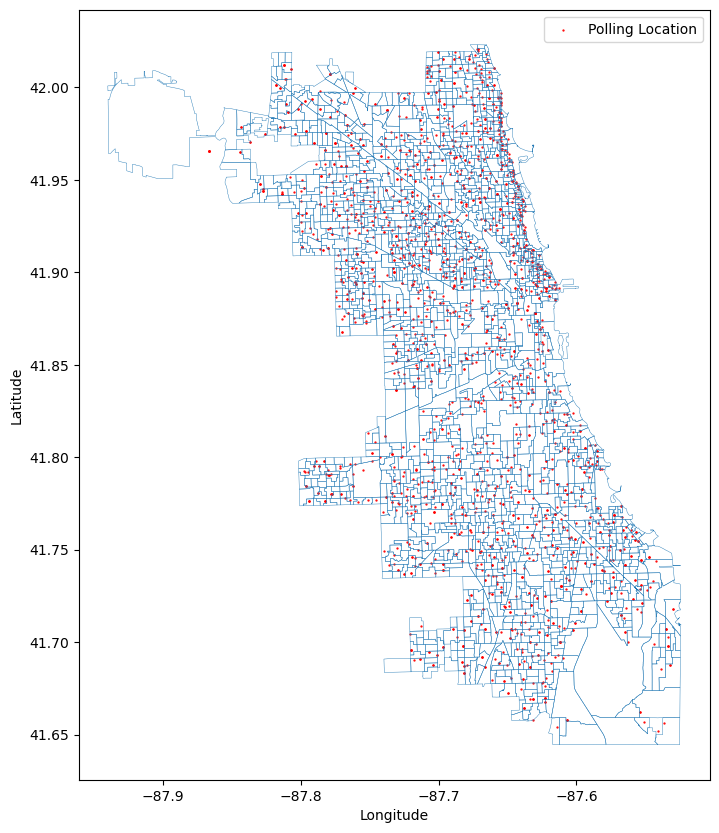

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
precs.boundary.plot(ax=ax,lw=.3)
ax.scatter(precs.polling_lon,precs.polling_lat,s=.4,color='r', label="Polling Location")
plt.legend()

# Checking that our census tract/precinct averaging scheme makes sense

<Axes: xlabel='Longitude', ylabel='Latitude'>

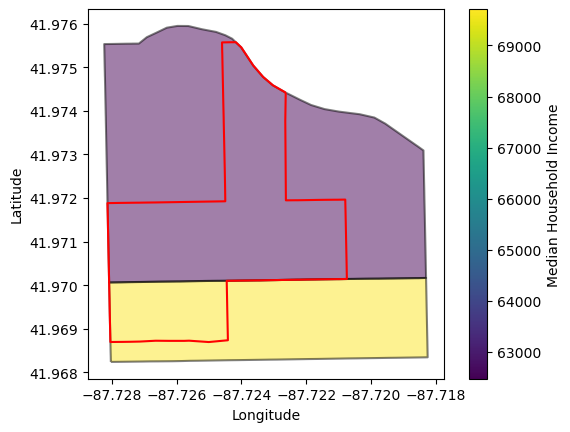

In [9]:
ii = 0
#Omitting ones that don't REALLY intersect (they share a boundary but it's imperfect, so once weighted by population in a near zero area, don't matter
icen = reading_data.index_str_to_list(precs.iloc[ii].census_indices)[0:2] 
fig = plt.figure()
ax = fig.add_subplot()
cen.iloc[icen].plot(column='median_household_income',ax=ax,alpha=.5,vmin=62478,vmax=69712,
                    legend_kwds={"label": "Median Household Income"}, legend=True)
cen.iloc[icen].boundary.plot(ax=ax,alpha=.5,color='k')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
precs.iloc[[ii]].boundary.plot(ax=ax,color='r')

Text(117.68740266007264, 0.5, 'Latitude')

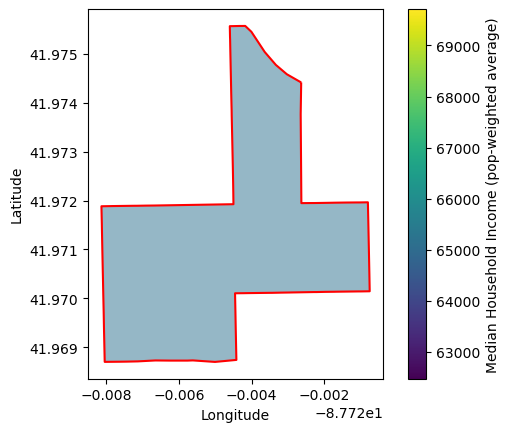

In [10]:
fig = plt.figure()
ax = fig.add_subplot()
precs.iloc[[ii]].plot(column='median_household_income_cen',ax=ax,alpha=.5,vmin=62478,vmax=69712,
                    legend_kwds={"label": "Median Household Income (pop-weighted average)"},legend=True)
precs.iloc[[ii]].boundary.plot(ax=ax,color='r')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

<Axes: xlabel='Longitude', ylabel='Latitude'>

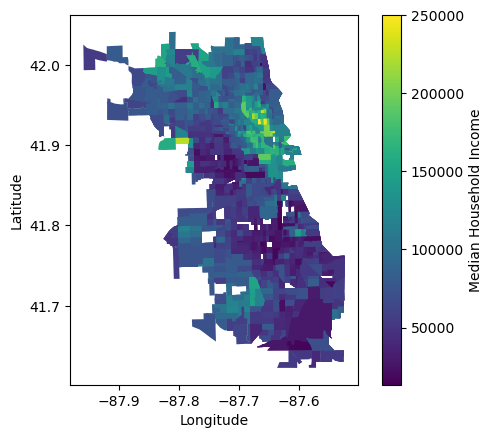

In [11]:
icenprec_arrays = [reading_data.index_str_to_list(prec.census_indices) for jj,prec in precs.iterrows()]
icenprecs = []
for i_array in icenprec_arrays:
    icenprecs += i_array
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude') 
cen.iloc[icenprecs].plot(ax=ax,column='median_household_income',legend=True,legend_kwds={"label": "Median Household Income"},
                         vmin=np.min(cen.median_household_income), vmax=np.max(cen.median_household_income))


<Axes: xlabel='Longitude', ylabel='Latitude'>

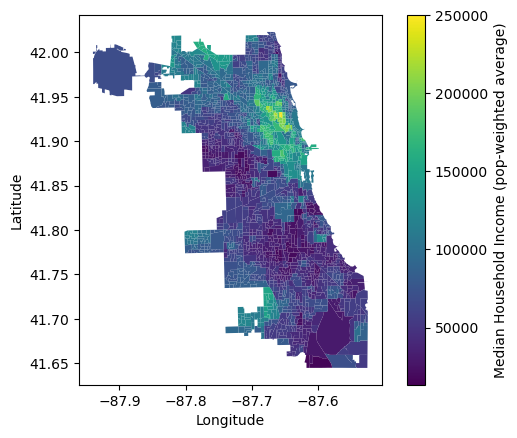

In [12]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
precs.plot(ax=ax,column='median_household_income_cen',legend=True,legend_kwds={"label": "Median Household Income (pop-weighted average)"},
           vmin=np.min(cen.median_household_income), vmax=np.max(cen.median_household_income))

# Looking at voter turnout by precinct

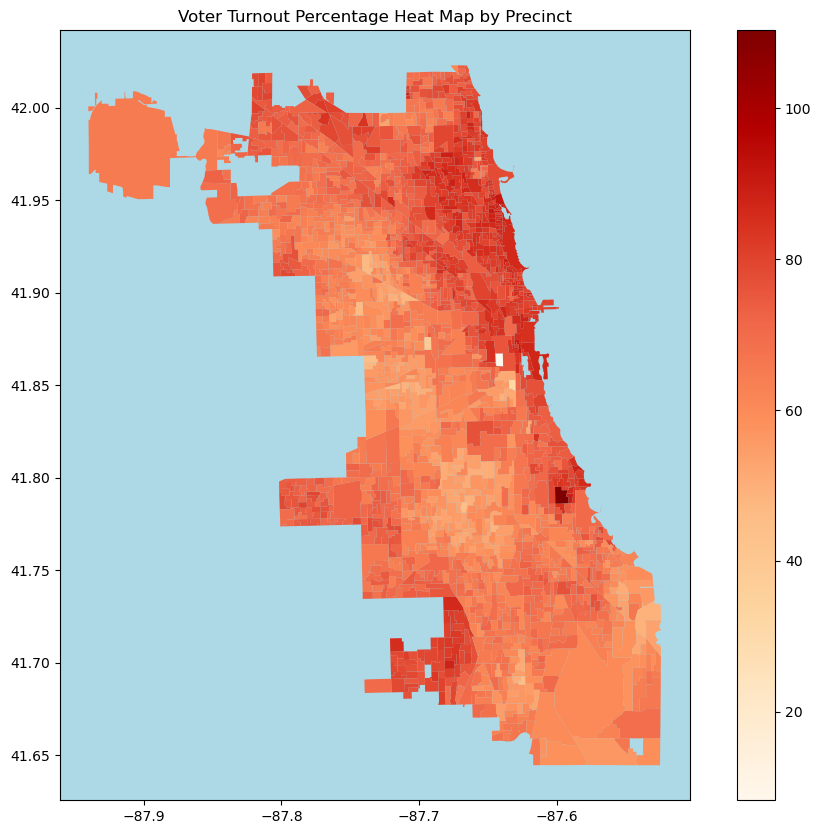

In [24]:

# Plot the GeoDataFrame with 'VoterTurnoutPercentage' as a heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.set_facecolor('lightblue')

precs.plot(column='VoterTurnoutPercentage', ax=ax, legend=True, cmap='OrRd')


plt.title('Voter Turnout Percentage Heat Map by Precinct')

#plt.savefig('voter_turnout_heatmap.png', dpi=300)

plt.show()

## Double-Checking Anomalous Voter Turnout

Two precincts were stark outliers in the data--Ward 11 Precinct 2 (at 8\% turnout) and Ward 5 Precinct 27 (at 110\% tunrout). We want to verify the vote counts from another source, from the [MIT Election Data & Science Lab](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/LYWX3D/C5CS03&version=11.1&toolType=PREVIEW). This is a very large dataset (~500 MB), as it contains election returns by precinct for the entire United States for the 2016 Presidential Election. Note you have to unzip this file in project_data/chc/ before running the cells below

In [26]:
df1 = pd.read_csv('../project_data/chc/2016-precinct-president.csv', encoding='ISO-8859-1', low_memory=False)

features = ['state','jurisdiction','candidate_normalized','precinct','votes'] 
df1 = df1[features]
chc_df = df1[(df1['state']=='Illinois') & (df1['jurisdiction']=='COOK')] 
# Cook county comprises the city of Chicago and suburban Cook county 
# Chicago's precincts are all of the form 'Ward #1 Precinct #2', so we filter by those entries starting with 'W'
chc_df = chc_df[chc_df['precinct'].str.startswith('W')] 

In [27]:
chc_df = chc_df.groupby('precinct')['votes'].sum().reset_index()

In [28]:
chc_df[['Ward', 'Precinct']] = chc_df['precinct'].str.extract(r'Ward (\d+) Precinct (\d+)')
chc_df[['Ward', 'Precinct']] = chc_df[['Ward', 'Precinct']].astype(int)

In [29]:
chc_df = chc_df.drop('precinct',axis=1)

In [30]:
chc_df.head()

,votes,Ward,Precinct
0,632,1,1
1,596,1,2
2,741,1,3
3,714,1,4
4,711,1,5


In [31]:
# Retrieve vote count given df and Ward+Precinct values

def lookup_votes(df,ward_value, precinct_value):
    result = df[(df['Ward'] == ward_value) & (df['Precinct'] == precinct_value)]['votes']
    
    # Ensure there is exactly one match and return the value
    if not result.empty:
        return result.values[0]  # Retrieve the first (and only) value
    else:
        return "No match found"


In [32]:
lookup_votes(chc_df,11,2)

np.int64(86)

In [33]:
lookup_votes(chc_df,5,27)

np.int64(866)

In [38]:
# Search through both dataframes and return any values of Ward & Precinct with mismatched vote counts
grouped_df = pd.read_csv('../project_data/processed_data/precinct_turnout.csv')
def find_vote_mismatches(df1, df2):
    mismatches = []

    for index, row in df1.iterrows():
        ward_value = row['Ward']
        precinct_value = row['Precinct']
        votes1 = row['votes']

        # Use lookup_votes to get votes from df2
        votes2 = lookup_votes(df2, ward_value, precinct_value)

        # Compare votes and record mismatches
        if votes1 != votes2:
            mismatches.append((ward_value, precinct_value, votes1, votes2))
    
    return mismatches

mismatched_votes = find_vote_mismatches(grouped_df, chc_df)

In [39]:
print(mismatched_votes)

[]


The vote counts are verified! 

## Heat Maps


In [ ]:

geo_census_data = gpd.read_file('../project_data/processed_data/Chicago_geocensus_data.geojson')
geo_census_data.plot(column='total_population', legend=True,
                     legend_kwds={"label": "Total population"})
geo_census_data.plot(column='median_household_income', legend=True,
                     legend_kwds={"label": "Median household income"})